2024-12-18 14:40:02.895228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734532802.909937 3293369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734532802.914491 3293369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 14:40:02.930057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103991 entries, 0 to 103990
Data columns (total 43 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       103991 non-null  int64  
 1   1       103991 non-null  object 
 2   2       103991 non-null  object 
 3   3       103991 non-null  object 
 4   4       103991 non-null  int64  
 5   5       103991 non-null  int64  
 6   6       103991 non-null  int64  
 7   7       103991 non-null  int64  
 8   8       103991 non-null  int64  
 9   9       103991 non-null  int64  
 10  10      103991 non-null  int64  
 11  11      103991 non-null  int64  
 12  12      103991 non-null  int64  
 13  13      103991 non-null  int64  
 14  14      103991 non-null  int64  
 15  15      103991 non-null  int64  
 16  16      103991 non-null  int64  
 17  17      103991 non-null  int64  
 18  18      103991 non-null  int64  
 19  19      103991 non-null  int64  
 20  20      103991 non-null  int64  


/tmp/ipykernel_3293369/2937213936.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


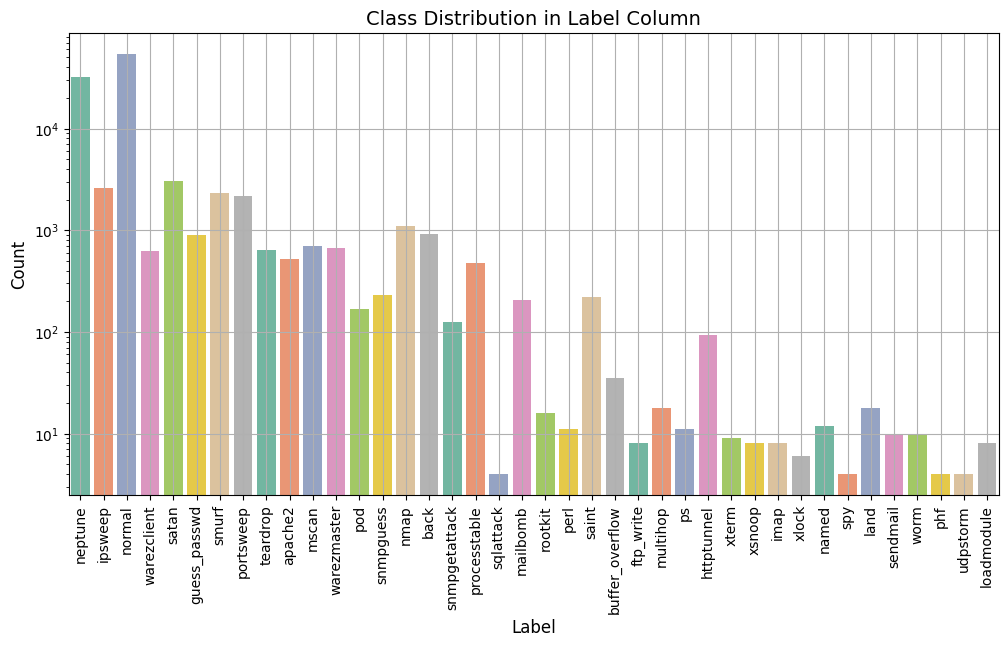

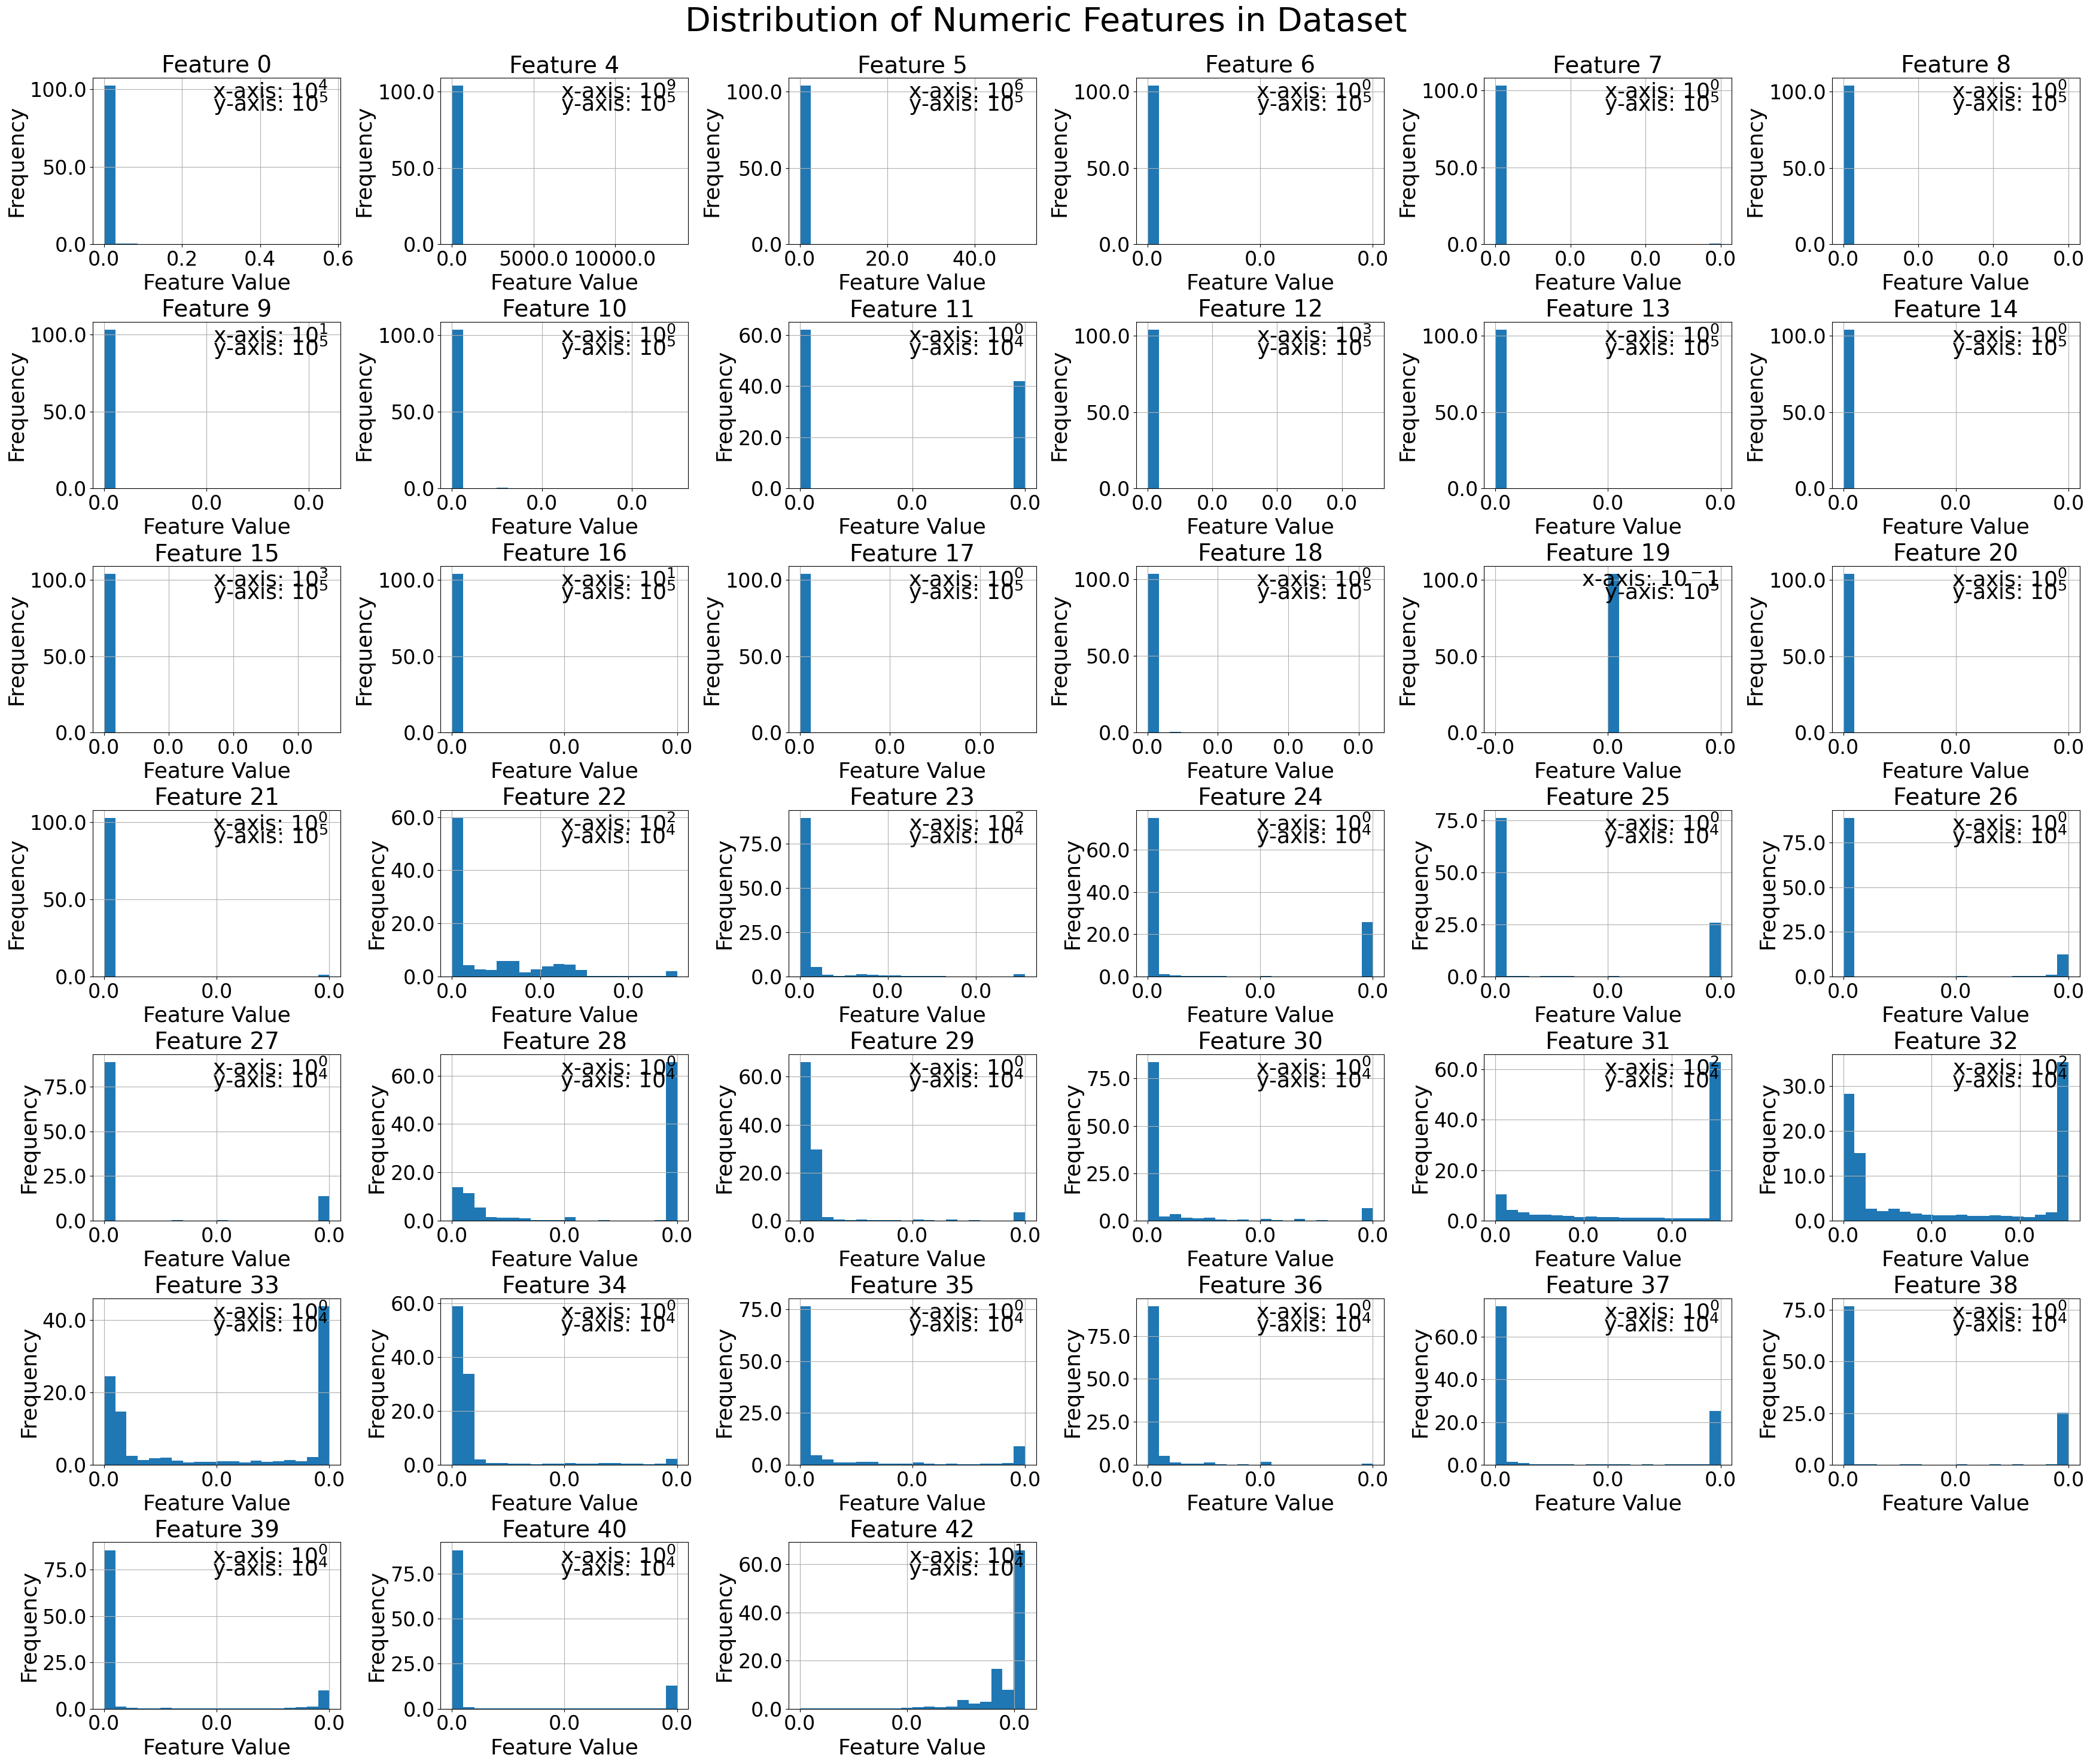

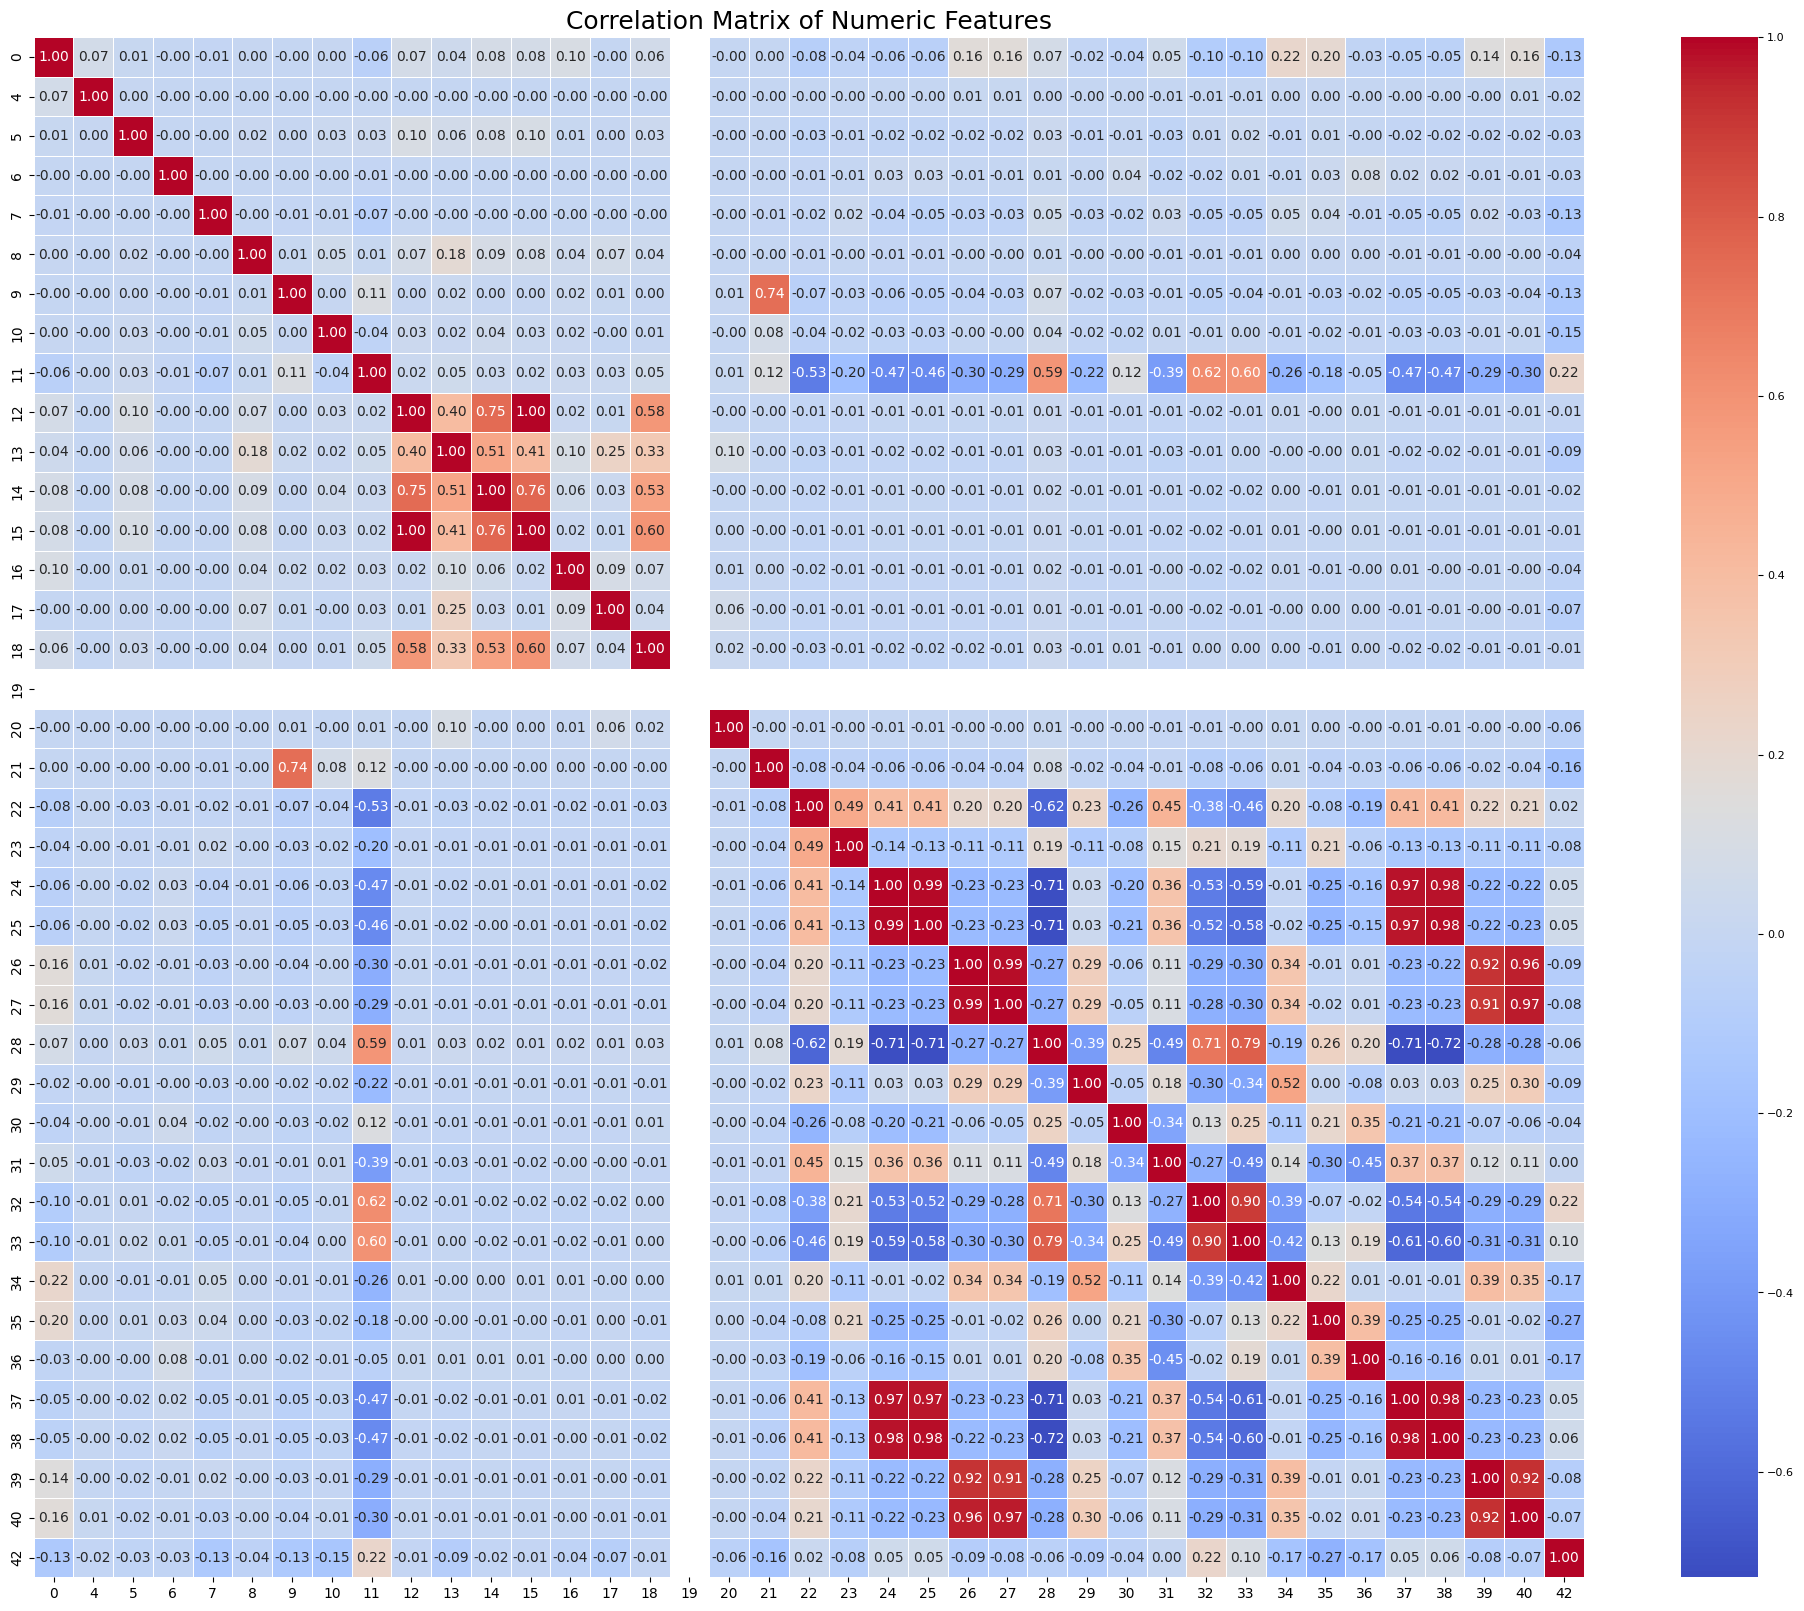

In [1]:
import import_ipynb
%run NSL-KDD_data_preprocessing.ipynb


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class TimeNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, kernel_size=3, num_filters=64, dropout=0.5, dilation_rates=[1, 2, 4]):
        super(TimeNet, self).__init__()

        # Step 1: Temporal Convolutional Layers for feature extraction
        # Adjust padding to match the dilation
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, stride=1, padding=(dilation_rates[0] * (kernel_size - 1)) // 2, dilation=dilation_rates[0])  # Dilated convolution
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, stride=1, padding=(dilation_rates[1] * (kernel_size - 1)) // 2, dilation=dilation_rates[1])
        self.conv3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=kernel_size, stride=1, padding=(dilation_rates[2] * (kernel_size - 1)) // 2, dilation=dilation_rates[2])

        # Step 2: Residual Connections (skip connections)
        self.residual1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=1, stride=1, padding=0)
        self.residual2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=1, stride=1, padding=0)
        self.residual3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=1, stride=1, padding=0)

        # Step 3: Fully connected layers (for classification)
        self.fc1 = nn.Linear(num_filters * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Ensure input shape is [batch_size, channels, length]
        
        # Apply temporal convolution layers with residual connections
        res1 = self.residual1(x)  # Residual connection for the first layer
        x = self.conv1(x) + res1  # Adding residual to the convolution output
        x = torch.relu(x)
        
        res2 = self.residual2(x)  # Residual connection for the second layer
        x = self.conv2(x) + res2  # Adding residual to the convolution output
        x = torch.relu(x)
        
        res3 = self.residual3(x)  # Residual connection for the third layer
        x = self.conv3(x) + res3  # Adding residual to the convolution output
        x = torch.relu(x)

        # Step 3: Flatten the output for fully connected layers
        x = x.mean(dim=2)  # Global average pooling to reduce dimensionality (seq_len dimension)

        # Step 4: Use fully connected layers
        x = torch.relu(self.fc1(x))  # [batch_size, hidden_dim]
        x = self.dropout(x)
        x = self.fc2(x)  # [batch_size, num_classes]

        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels, patience=5):
    num_classes = len(labels)
    input_dim = X_train.shape[1]
    model = TimeNet(input_dim=input_dim, num_classes=num_classes).to(device)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, threshold=1e-6, min_lr=1e-6)

    # Reshape the data for Conv1d (adding channel dimension)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (samples, 1, input_dim)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long).to(device))
    val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long).to(device))
    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Early stopping variables
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_weights = None

    # Training loop
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_accuracy = correct / total
        val_loss /= len(val_loader)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs with no improvement in validation accuracy.")
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    test_accuracy = correct / total

    # Print test set accuracy
    print(f"NSL-KDD_TimeNet_accuracy: {test_accuracy:.6f}")

    return model, labels, y_true, y_pred


# Call the function
model, labels, y_test_true, y_test_pred = train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels)


Epoch 1, Loss: 1398.019700, Validation Loss: 0.181491, Validation Accuracy: 0.944218, Learning Rate: 0.001000
Epoch 2, Loss: 614.402837, Validation Loss: 0.126662, Validation Accuracy: 0.962797, Learning Rate: 0.001000
Epoch 3, Loss: 473.473272, Validation Loss: 0.110059, Validation Accuracy: 0.966925, Learning Rate: 0.001000
Epoch 4, Loss: 399.799159, Validation Loss: 0.106569, Validation Accuracy: 0.967643, Learning Rate: 0.001000
Epoch 5, Loss: 349.699606, Validation Loss: 0.089611, Validation Accuracy: 0.971548, Learning Rate: 0.001000
Epoch 6, Loss: 312.627041, Validation Loss: 0.082288, Validation Accuracy: 0.974106, Learning Rate: 0.001000
Epoch 7, Loss: 292.425874, Validation Loss: 0.084029, Validation Accuracy: 0.973208, Learning Rate: 0.001000
Epoch 8, Loss: 271.963238, Validation Loss: 0.089581, Validation Accuracy: 0.970875, Learning Rate: 0.001000
Epoch 9, Loss: 256.273288, Validation Loss: 0.081053, Validation Accuracy: 0.975273, Learning Rate: 0.001000
Epoch 10, Loss: 24

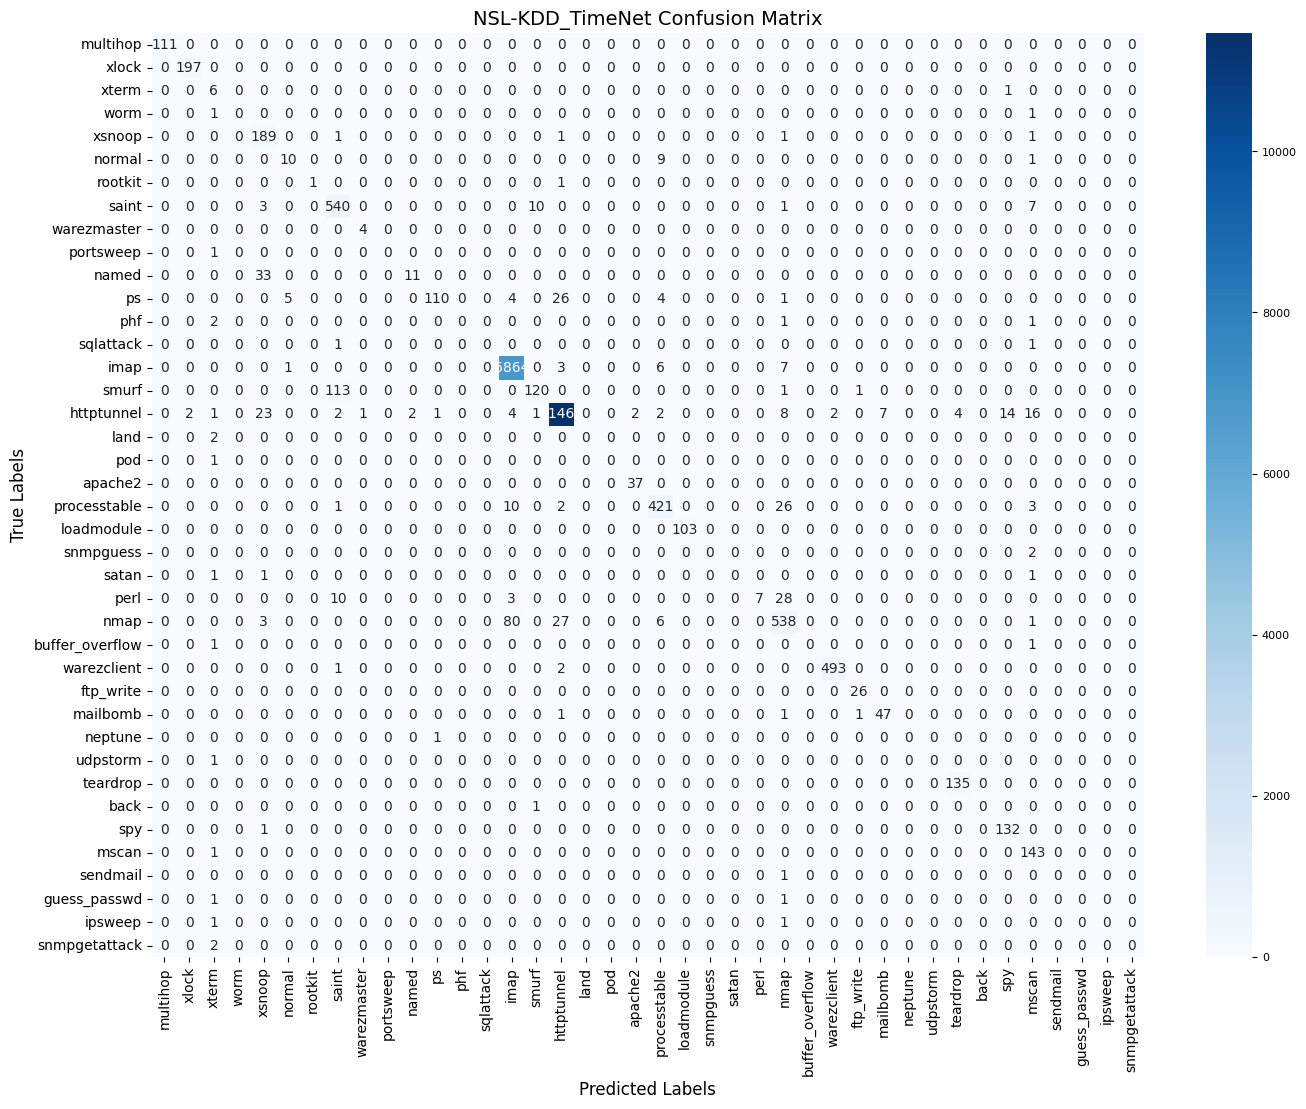

NSL-KDD_TimeNet Classification Report:
                 precision    recall  f1-score   support

       multihop       1.00      1.00      1.00       111
          xlock       0.99      1.00      0.99       197
          xterm       0.27      0.86      0.41         7
           worm       0.00      0.00      0.00         2
         xsnoop       0.75      0.98      0.85       193
         normal       0.62      0.50      0.56        20
        rootkit       1.00      0.50      0.67         2
          saint       0.81      0.96      0.88       561
    warezmaster       0.80      1.00      0.89         4
      portsweep       0.00      0.00      0.00         1
          named       0.85      0.25      0.39        44
             ps       0.98      0.73      0.84       150
            phf       0.00      0.00      0.00         4
      sqlattack       0.00      0.00      0.00         2
           imap       0.99      1.00      0.99      6881
          smurf       0.91      0.51      0.65  

/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting confusion matrix for Meta Model
cm_meta = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm_meta, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 10})
plt.title("NSL-KDD_TimeNet Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

print("NSL-KDD_TimeNet Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels))
